# X2K Appyter

The X2K Appyter (Expression2Kinases) predicts upstream regulatory networks associated with user-inputted sets of genes. Discrete query gene sets are compared first to ChEA3 libraries of transcription factor target gene sets assembled from orthogonal 'omics' datasets. Afterwards, ChEA3 results are put through a protein-protein interaction database to determine the transcription factor intermediate protein interactors. Finally, protein interactors are compared to the KEA3 background database—which contains measured and predicted kinase-substrate interactions, kinase-protein interactions, and interactions supported by co-expression and co-occurrence data—to determine which kinases may be most closely associated with the transcription factor intermediate protein interactors. Overall, Expression2Kinases can provide a method of identifying upstream regulators likely responsible for observed patterns in genome-wide gene expression.


In [1]:
# Install required packages
!pip install observable-jupyter tabulate plotly

# Imports
from time import sleep
from tabulate import tabulate
from observable_jupyter import embed
from IPython.display import HTML, display, Image, FileLink, Markdown
import plotly.graph_objects as go

In [2]:
!pip install glasbey


In [3]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

from google.colab import drive
drive.mount('/content/drive', force_remount=True)
root_dir = "/content/drive/My Drive/"
project_folder = "Thesis_MSc"
os.chdir(root_dir + project_folder)
!pwd

Mounted at /content/drive
/content/drive/My Drive/Thesis_MSc


In [4]:
### Might want to make this an input field? Where you can choose among a variety of databases?
#{% set ppi_dataset = ChoiceField(
    #name = 'ppi_dataset',
    #label = 'Protein-Protein Interaction Database',
    #choices = {'PCA': 'PCA', 'UMAP': 'UMAP', 't-SNE': 't-SNE'},
    #default = 'BioGrid',
    #description = 'Select a protein-protein interaction database to be used in analysis.',
    #section = 'input')
#%}

In [5]:
import requests
import json
from time import sleep

# Function to call the ChEA3 API
def get_chea3_results(gene_set, query_name):
    ADDLIST_URL = 'https://maayanlab.cloud/chea3/api/enrich/'
    payload = {
        'gene_set': gene_set,
        'query_name': query_name
    }
    response = requests.post(ADDLIST_URL, data=json.dumps(payload))
    if not response.ok:
        raise Exception('Error analyzing gene list')
    sleep(1)
    return response.json()


# Function to call the KEA3 API
def get_kea3_results(gene_set, query_name):
    ADDLIST_URL = 'https://maayanlab.cloud/kea3/api/enrich/'
    payload = {
        'gene_set': gene_set,
        'query_name': query_name
    }
    response = requests.post(ADDLIST_URL, data=json.dumps(payload))
    if not response.ok:
        raise Exception('Error analyzing gene list')
    sleep(1)
    return response.json()


# Function to find the index of a value in a list (ignoring zeros)
def indexfinder(lib_score_list, value):
    index = 1
    for num in lib_score_list:
        if num == value:
            return index
        elif num != 0:
            index += 1
    return None


In [6]:
#B cell decrease
# this cell extracts the gene list, whether it was pasted in, or uploaded as a file # for if the gene list was pasted in
geneset =  [
    "CD86", "CDKN1A", "CD83", "SERPINE1", "CTCF", "NRF1", "NOD2", "PTGS2", "FOXO3",
    "HIF1A", "ICAM1", "TNFSF13B", "YY1", "MYC", "HES1", "UPP1", "CTSB", "CCL22",
    "TBP", "TSLP", "TNFSF14", "VWF", "PLAUR", "F3", "NFKB1", "PSMB9", "COL1A1",
    "CREB3", "ELF3", "ADORA2A", "CDK4", "IRF4", "IRF1", "BCL3", "BCL2", "IRF7",
    "SDC1", "TLR7", "TLR2", "HBEGF"
]

num_tfs = 10
num_kins = 10
# also extracts the integer inputted for number of transcription factors to be returned
threshold = 3

In [7]:
# This cell parses the gene list input into an organized python list
genes = [x.strip() for x in geneset]
print(genes)

['CD86', 'CDKN1A', 'CD83', 'SERPINE1', 'CTCF', 'NRF1', 'NOD2', 'PTGS2', 'FOXO3', 'HIF1A', 'ICAM1', 'TNFSF13B', 'YY1', 'MYC', 'HES1', 'UPP1', 'CTSB', 'CCL22', 'TBP', 'TSLP', 'TNFSF14', 'VWF', 'PLAUR', 'F3', 'NFKB1', 'PSMB9', 'COL1A1', 'CREB3', 'ELF3', 'ADORA2A', 'CDK4', 'IRF4', 'IRF1', 'BCL3', 'BCL2', 'IRF7', 'SDC1', 'TLR7', 'TLR2', 'HBEGF']


In [8]:
###### getting results from the ChEA3 API ######
chea3results = get_chea3_results(genes, 'query')

# so to clarify, "genes" are the user inputted genes (from the input page)
# "results" is the list of transcription factors that is returned by the ChEA3 API in
# response to the inputted genes

In [9]:
###### Read in the PPI Database being used ######

ppi_url = 'https://appyters.maayanlab.cloud/storage/X2K_Appyter/BioGrid-6-23-21.csv'
ppi = pd.read_csv(ppi_url)
# this will need to be updated in the future so that the appyter works for people who
# don't already have this BioGrid file on their local machine

In [10]:
mr_chea3results = chea3results['Integrated--meanRank']

chea3libs_sorted = sorted({lib.partition(',')[0] for result in mr_chea3results for lib in result['Library'].split(';')})

for i in range(len(mr_chea3results)):
    for lib in chea3libs_sorted:
        mr_chea3results[i].update({lib:0})

for i in range(len(mr_chea3results)):
    thing = mr_chea3results[i]['Library'].split(';')
    for a in range(len(thing)):
        library, value = thing[a].split(',')
        mr_chea3results[i].update({library:int(value)})

In [11]:
mr_chea3resultsSorted = {
  lib: sorted(mr_chea3results, key = lambda k: k[lib])
  for lib in chea3libs_sorted
}

mr_chea3resultsRanked = {
  lib: [entry[lib] for entry in mr_chea3resultsSorted[lib]]
  for lib in chea3libs_sorted
}

chea3ranking_dict = {
  lib: mr_chea3resultsRanked[lib]
  for lib in chea3libs_sorted
}

In [12]:
for tfentry in mr_chea3results:
    tfentry.update( [('SumRank', 0), ('AvgRank', 0) ])
    library_scores = tfentry['Library'].split(';')
    lib_counter = 0
    for a in library_scores:
        l, v = a.split(',')
        v = int(v)
        scorerank = indexfinder(chea3ranking_dict[l], int(v))
        tfentry['SumRank'] += int(scorerank)
        lib_counter += 1
    tfentry['AvgRank'] = (tfentry['SumRank'] / lib_counter)

sorted_chea3results = sorted(mr_chea3results, key = lambda k: k['AvgRank'])

In [13]:
try:
    tf_score_threshold
except NameError:
    toptfs = []
    tf_index = 0
    while (len(toptfs) < num_tfs):
        if len(sorted_chea3results[tf_index]['Library'].split(';')) >= threshold:
            toptfs.append(sorted_chea3results[tf_index])
        tf_index += 1
else:
    toptfs = [sorted_chea3results[i] for i in range(len(sorted_chea3results)) \
              if len(sorted_chea3results[i]['Library'].split(';')) >= threshold \
              if float(sorted_chea3results[i]['Score']) <= tf_score_threshold]
#toptfs = [chea3_lib_results[i] for i in range(len(chea3_lib_results)) \
          #if float(chea3_lib_results[i]['Score']) <= score_threshold]
# if a TFs score meets the threshold value, adds this TF (and its data) to the toptfs list

toptfnames = [i['TF'] for i in toptfs]
# makes a list of just the names of the top TFs

In [14]:
###### Setting up the PPI Dictionary ######

# ppi_dict is a dictionary where the key is a tf, and the value is a list of all the possible
# interactors of this tf (based on the ppi database)

ppi_dict = {}

for i in range(ppi.shape[0]):
    ppi_dict.update({ppi.Gene_A[i]:[]})

for i in range(ppi.shape[0]):
    ppi_dict[ppi.Gene_A[i]].append(ppi.Gene_B[i])

### Transcription Factors and Their Interactors

In [15]:
###### Makes a dictionary for the top tfs only ######

# ppi_dict is a dictionary of the entire ppi databaes
# top_dict is that same dictionary, but filtered to only include the tfs in toptfnames

top_dict = {}

for name in toptfnames:
    if ppi_dict.get(name):
        top_dict.update({name:ppi_dict.get(name)})
    else:
        top_dict.update({name: 'No known interactors'})

In [16]:
###### Makes a list, top_tf_interactors ######

# tf_interactors = list containing all the interactors per tf in toptfnames
# top_tf_interactors = list containing all the interactors that are shared by at least 2 top tfs

tf_interactors = [j for i in top_dict.values() if i != 'No known interactors' for j in i]

top_tf_interactors = []

for tf in tf_interactors:
    count = 0
    for i in top_dict.items():
        for interactor in i[1]:
            if interactor == tf:
                count += 1
    if count >= 2:
        top_tf_interactors.append(tf)

top_tf_interactors = [i for n, i in enumerate(top_tf_interactors)
                      if i not in top_tf_interactors[:n]]

In [17]:
###### Now putting the top_tf_interactors through KEA3 #######

kea3results = get_kea3_results(top_tf_interactors, 'query')

In [18]:
###### Getting Ready To Investigate the Top Ranked Kinases ######

mr_kea3results = kea3results['Integrated--meanRank']

kea3libs_sorted = sorted({lib.partition(',')[0] for result in mr_kea3results for lib in result['Library'].split(';')})

for i in range(len(mr_kea3results)):
    for lib in kea3libs_sorted:
        mr_kea3results[i].update({lib:0})

for i in range(len(mr_kea3results)):
    thing = mr_kea3results[i]['Library'].split(';')
    for a in range(len(thing)):
        library, value = thing[a].split(',')
        mr_kea3results[i].update({library:int(value)})

In [19]:
###### Sorting Kinases According to Rank in Each Library #######
mr_kea3resultsSorted = {
  lib: sorted(mr_kea3results, key = lambda k: k[lib])
  for lib in kea3libs_sorted
}

mr_kea3resultsRanked = {
  lib: [entry[lib] for entry in mr_kea3resultsSorted[lib]]
  for lib in kea3libs_sorted
}

# Composes a dictionary of all the kinases where each entry is the kinases ranked
# according to the respective library (the library name is the key in the dictionar)
kea3ranking_dict = {
  lib: mr_kea3resultsRanked[lib]
  for lib in kea3libs_sorted
}

In [20]:
###### Sorting the kinases by AvgRank #######

for tfentry in mr_kea3results:
    tfentry.update( [('SumRank', 0), ('AvgRank', 0) ])
    library_scores = tfentry['Library'].split(';')
    lib_counter = 0
    for a in library_scores:
        l, v = a.split(',')
        v = int(v)
        scorerank = indexfinder(kea3ranking_dict[l], int(v))
        tfentry['SumRank'] += int(scorerank)
        lib_counter += 1
    tfentry['AvgRank'] = (tfentry['SumRank'] / lib_counter)

sorted_kea3results = sorted(mr_kea3results, key = lambda k: k['AvgRank'])

In [21]:
###### Getting the List of Sorted Kinases ######

try:
    kin_score_threshold
except NameError:
    sorted_topkinresults = []
    kin_index = 0
    while (len(sorted_topkinresults) < num_kins):
        if len(sorted_kea3results[kin_index]['Library'].split(';')) >= threshold:
            sorted_topkinresults.append(sorted_kea3results[kin_index])
        kin_index += 1
else:
    sorted_topkinresults = [mr_kea3results[i] for i in range(len(sorted_kea3results)) \
                            if len(sorted_kea3results[i]['Library'].split(';')) >= threshold \
                            if float(mr_kea3results[i]['Score']) <= kin_score_threshold]

In [22]:
topkinnames = [i['TF'] for i in sorted_topkinresults]

# Network Summary

## Transcription Factors and Their Interactors

### Highest Ranked Transcription Factors

In [23]:
display(HTML(', '.join(toptfnames)))

In [24]:
import glasbey

# chea3libs_sorted = list of libraries you want in your chart
c_lib_palette = dict(
    zip(
        chea3libs_sorted,
        glasbey.create_palette(len(chea3libs_sorted), colorblind_safe=True)
    )
)


In [25]:
c_lib_palette = dict(zip(chea3libs_sorted, glasbey.create_palette(len(chea3libs_sorted), colorblind_safe=True)))

tf_amt = len(toptfs)

c_lib_means = {lib: [0] * tf_amt for lib in chea3libs_sorted}

toptfs = toptfs[::-1]
# Assume chea3ranking_dict contains all libraries
c_lib_means = {lib_name: [0] * len(toptfs) for lib_name in chea3ranking_dict.keys()}

# set up a list with all the TFs, sorted by rank (lowest to highest, in line with top_results)
sorted_tfs = []
for i in range(0, len(toptfs)):
    sorted_tfs.append(toptfs[i].get('TF'))

for i, tfentry in enumerate(toptfs):
    libscores = tfentry['Library'].split(';')
    for a in libscores:
        lib, value = a.split(',')
        rank = indexfinder(chea3ranking_dict[lib], int(value))
        avg = tfentry['AvgRank']
        tot = tfentry['SumRank']
        bar_length = (rank*avg)/tot
        c_lib_means[lib][i] = float(bar_length)

In [26]:
# Initialize c_lib_means with libraries from chea3ranking_dict
c_lib_means = {lib_name: [0] * len(toptfs) for lib_name in chea3ranking_dict.keys()}

# Sorted TFs list
sorted_tfs = [tf.get('TF') for tf in toptfs]

for i, tfentry in enumerate(toptfs):
    lib_str = tfentry.get('Library', '')
    if not lib_str:
        continue

    lib_scores = lib_str.split(';')
    for lib_score in lib_scores:
        try:
            lib, value = lib_score.split(',')
            lib = lib.strip()
            value = int(value.strip())

            rank = indexfinder(chea3ranking_dict[lib], value)
            avg = float(tfentry.get('AvgRank', 1))
            tot = float(tfentry.get('SumRank', 1))

            bar_length = (rank * avg) / tot
            c_lib_means[lib][i] = bar_length
        except Exception as e:
            print(f"Skipping entry {lib_score}: {e}")


In [27]:
sorted_tfs = [tf.get('TF') for tf in toptfs]  # list of TF names

# Initialize c_lib_means if not already
# c_lib_means = {lib_name: [0]*len(toptfs) for lib_name in chea3ranking_dict.keys()}

for i, tfentry in enumerate(toptfs):
    # Make sure 'Library' is a string
    lib_str = tfentry.get('Library', '')
    if not lib_str:
        continue

    lib_scores = lib_str.split(';')  # separate libraries
    for lib_score in lib_scores:
        try:
            lib, value = lib_score.split(',')
            value = int(value.strip())

            rank = indexfinder(chea3ranking_dict[lib], value)
            avg = float(tfentry.get('AvgRank', 1))
            tot = float(tfentry.get('SumRank', 1))

            bar_length = (rank * avg) / tot
            c_lib_means[lib][i] = bar_length
        except Exception as e:
            print(f"Skipping entry {lib_score}: {e}")


# Plotting the actual bar chart
chea3_fig = go.Figure(data = [go.Bar(name = c_lib,
                                     x = c_lib_means[c_lib],
                                     y = sorted_tfs,
                                     marker = go.bar.Marker(color = c_lib_palette[c_lib]),
                                     orientation = 'h')
                              for c_lib in chea3libs_sorted])

chea3_fig.update_layout(barmode = 'stack')
chea3_fig.update_layout(
    title = {
        'text': 'Stacked Bar Chart of Average Ranks in Different Libraries',
        'y': 0.87,
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top',
    },
    xaxis_title = 'Average of Ranks Across All Libraries',
    yaxis_title = 'Transcription Factors',
    font = dict(
        size = 16,
        color = 'black'
    )
)

Image(chea3_fig.to_image(format='png'))

In [28]:
import plotly.graph_objects as go

# Display images in Jupyter/Colab
from IPython.display import Image

In [29]:
!pip install kaleido==0.2.1


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 9.5 MB/s eta 0:00:00


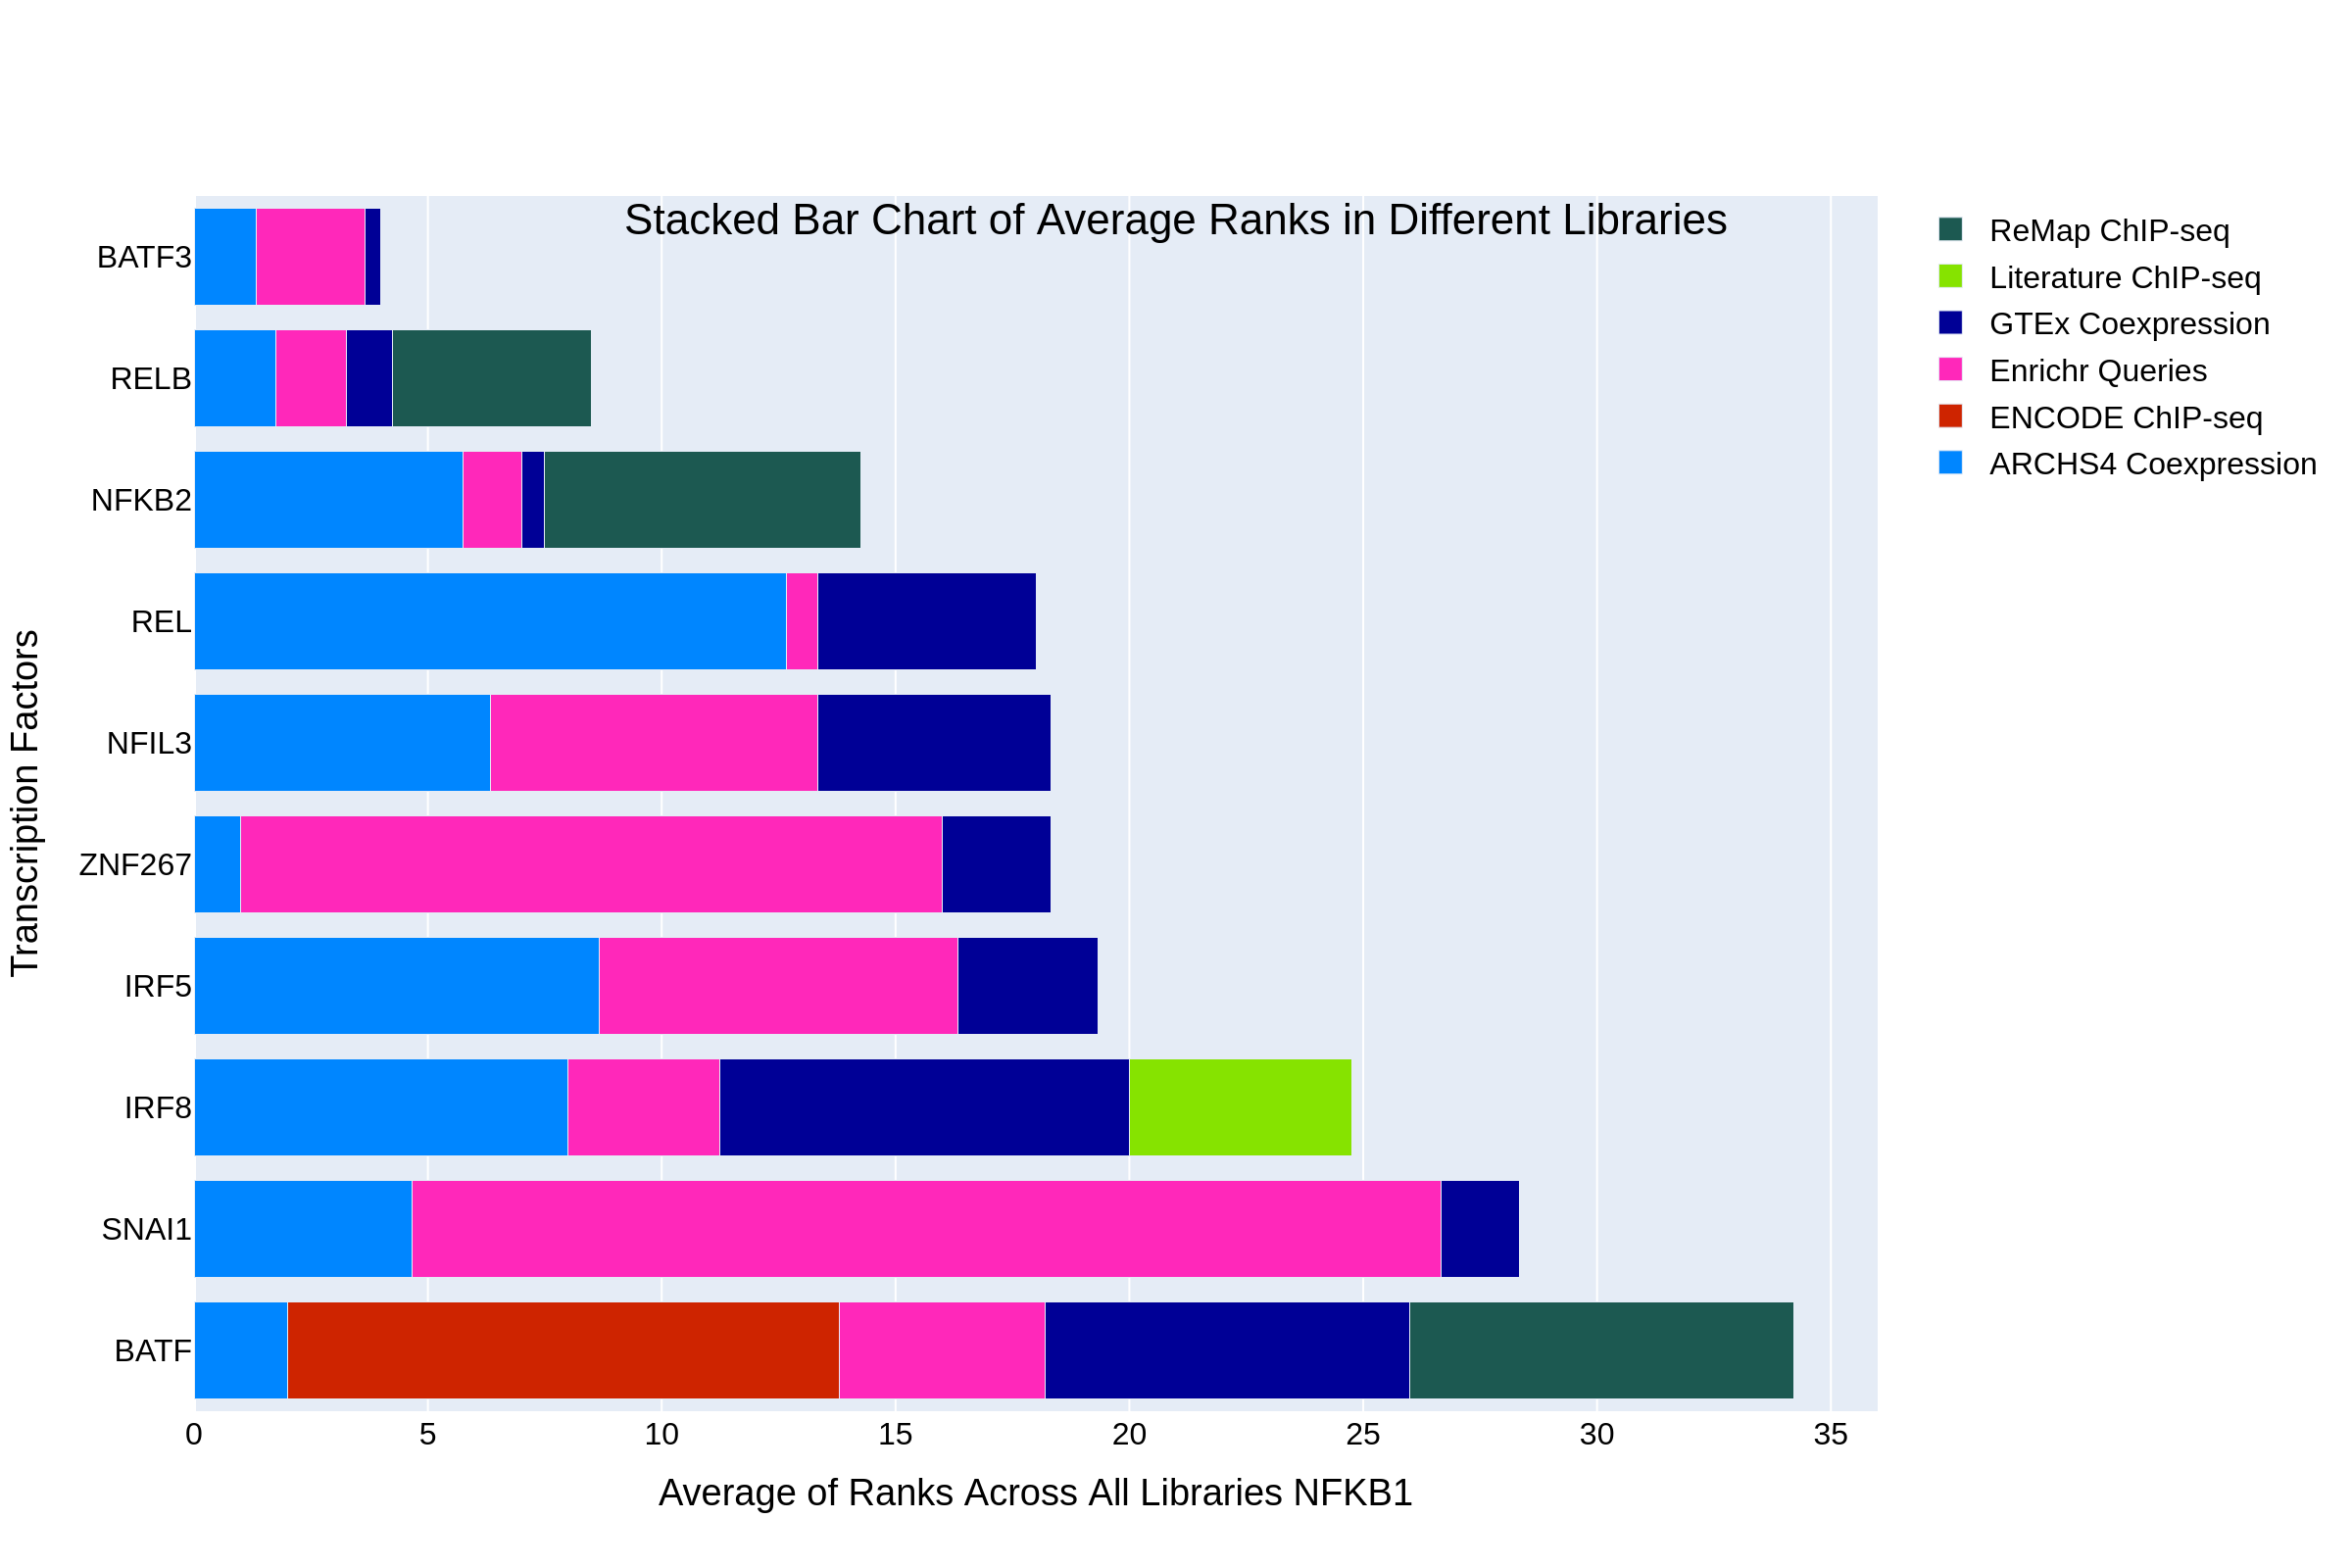

In [30]:
import plotly.graph_objects as go
from IPython.display import Image

# Your stacked bar chart
chea3_fig = go.Figure(
    data=[
        go.Bar(
            name=c_lib,
            x=c_lib_means[c_lib],
            y=sorted_tfs,
            marker=dict(color=c_lib_palette[c_lib]),
            orientation='h'
        )
        for c_lib in chea3libs_sorted
    ]
)

chea3_fig.update_layout(barmode='stack',
    title={
        'text': 'Stacked Bar Chart of Average Ranks in Different Libraries',
        'y':0.87, 'x':0.5, 'xanchor':'center', 'yanchor':'top'
    },
    xaxis_title='Average of Ranks Across All Libraries NFKB1',
    yaxis_title='Transcription Factors',
    font=dict(size=16, color='black')
)

# Show interactive chart
chea3_fig.show()

# Optional: export as PNG and display
img_bytes = chea3_fig.to_image(format='png', width=1200, height=800, scale=2)
Image(data=img_bytes)


In [31]:
chea3_fig.write_image("chea3_plot NFKB1.png")

###### Figure 1.1
The bar chart above is a mean rank bar chart of the highest ranked transcription factors from ChEA3. The y-axis displays the different transcription factors, and the x-axis displays the average mean rank of a transcription factor across all the available libraries.

In [32]:
chea3_mr_table = [0] * len(toptfs)

chea3_mr_counter = 0
# set up a counter for indexing (to fill mrtable)

tbl_toptfs = toptfs[::-1]

for i in range(len(tbl_toptfs)):
    tbl_toptfs[i]['Rank'] = i + 1

for i in tbl_toptfs:
    chea3_mr_table[chea3_mr_counter] = [i['Rank'],
                                        i['TF'],
                                        i['AvgRank'],
                                        i['Library'].replace(',', ': ').replace(';', ', '),
                                        f"{', '.join(i['Overlapping_Genes'].split(',')[0:10])}, ..."]
    # filling mrtable, using replace() to reformat a bit
    # [0:10] for Overlapping_Genes so that only 10 Overlapping Genes are shown (with '...' after)
    chea3_mr_counter += 1

# now actually making/printing the table
display(HTML(tabulate(chea3_mr_table, ['Rank',
                                       'Transcription Factor',
                                       'Avg Rank',
                                       'Library Ranks',
                                       'Overlapping Genes'],
                      tablefmt='html')))


chea3_tsv_name = 'transcriptionfactors.tsv'
with open(chea3_tsv_name, 'w') as tsv_file:
    tsv_file.write(tabulate(chea3_mr_table, ['Rank',
                                             'Transcription Factor',
                                             'Avg Rank',
                                             'Library Ranks',
                                             'Overlapping Genes'],
                            tablefmt='tsv'))
    display(HTML(f'<a href="{chea3_tsv_name}">Download table in .tsv</a>'))

Rank,Transcription Factor,Avg Rank,Library Ranks,Overlapping Genes
1,BATF3,4,"ARCHS4 Coexpression: 4, Enrichr Queries: 7, GTEx Coexpression: 1","CD86, CDKN1A, CD83, CCL22, TNFSF14, SERPINE1, PLAUR, PTGS2, NFKB1, ICAM1, ..."
2,RELB,8.5,"ARCHS4 Coexpression: 7, Enrichr Queries: 6, ReMap ChIP-seq: 17, GTEx Coexpression: 4","CD86, CDKN1A, CD83, SERPINE1, NOD2, PTGS2, HIF1A, ICAM1, MYC, UPP1, ..."
3,NFKB2,14.25,"ARCHS4 Coexpression: 23, Enrichr Queries: 5, ReMap ChIP-seq: 27, GTEx Coexpression: 2","CD86, CDKN1A, CD83, CCL22, TNFSF14, SERPINE1, PLAUR, NOD2, PTGS2, HIF1A, ..."
4,REL,18,"ARCHS4 Coexpression: 38, Enrichr Queries: 2, GTEx Coexpression: 14","CD86, CDKN1A, CD83, TNFSF14, SERPINE1, PLAUR, NOD2, PTGS2, FOXO3, HIF1A, ..."
5,NFIL3,18.3333,"ARCHS4 Coexpression: 19, Enrichr Queries: 21, GTEx Coexpression: 15","CD86, CDKN1A, CD83, SERPINE1, PLAUR, NOD2, FOXO3, PTGS2, HIF1A, ICAM1, ..."
6,ZNF267,18.3333,"ARCHS4 Coexpression: 3, Enrichr Queries: 45, GTEx Coexpression: 7","CD86, CDKN1A, CD83, TNFSF14, PLAUR, PTGS2, HIF1A, NFKB1, TNFSF13B, PSMB9, ..."
7,IRF5,19.3333,"ARCHS4 Coexpression: 26, Enrichr Queries: 23, GTEx Coexpression: 9","CD86, CDKN1A, CD83, SERPINE1, PLAUR, NOD2, PTGS2, NFKB1, PSMB9, ICAM1, ..."
8,IRF8,24.75,"Literature ChIP-seq: 19, ARCHS4 Coexpression: 32, Enrichr Queries: 13, GTEx Coexpression: 35","CD86, CDKN1A, CD83, PLAUR, PTGS2, NFKB1, PSMB9, ICAM1, TNFSF13B, IRF4, ..."
9,SNAI1,28.3333,"ARCHS4 Coexpression: 14, Enrichr Queries: 66, GTEx Coexpression: 5","CDKN1A, VWF, TSLP, SERPINE1, PLAUR, PTGS2, HIF1A, ICAM1, COL1A1, ADORA2A, ..."
10,BATF,34.2,"ARCHS4 Coexpression: 10, ENCODE ChIP-seq: 59, Enrichr Queries: 22, ReMap ChIP-seq: 41, GTEx Coexpression: 39","CD86, CDKN1A, CD83, CCL22, TNFSF14, SERPINE1, PLAUR, NOD2, FOXO3, PTGS2, ..."


###### Table 1.1
The table above represents the top ranked transcription factors from ChEA3. Rows are different transcription factors, columns are various attributes associated with a single transcription factor.

### Transcription Factor Interactors

"Transcription factor interactors" are any molecules that interact with the given transcription factor according to the protein-protein interaction database.

In [33]:
for name in toptfnames:
    if ppi_dict.get(name):
        display(HTML(f"{name} interacts with {len(ppi_dict.get(name))} gene(s)/protein(s):"))
        display(HTML(', '.join(ppi_dict.get(name))))
    else:
        display(HTML(f"{name} has no known interactors."))
    display(HTML(f"<hr>"))
    print('')

###### Table 2.1

The table above lists all the interactors for a specific top ranked transcription factor. The data is drawn from the BioGRID protein-protein interaction databsae.

## Relevant Transcription Factor Interactors

"Relevant transcription factor interactors" are transcription factor interactors that are shared among at least 2 of the top trasncription factors themselves.

In [34]:
display(HTML(f"There are {len(top_tf_interactors)} relevant transcription factor interactors:"))
display(HTML(', '.join(top_tf_interactors)))

In [35]:
rtf_fortable = []

for i in range(len(top_tf_interactors)):
    rtf_fortable.append([i+1, top_tf_interactors[i]])

display(HTML(tabulate(rtf_fortable, ['','TF Interactors'], tablefmt='html')))

rtf_tsv_name = 'tf_interactors.tsv'
with open(rtf_tsv_name, 'w') as tsv_file:
    tsv_file.write(tabulate(rtf_fortable, ['','TF Interactors'], tablefmt='tsv'))
    display(HTML(f'<a href="{rtf_tsv_name}">Download table in .tsv</a>'))

,TF Interactors
1,BATF
2,ATF3
3,ATF4
4,ATF2
5,DBP
6,CEBPE
7,CEBPA
8,CEBPG
9,GOPC
10,EEF1D


###### Table 2.2
Displays all most relevant transcription factor interactors, defined as transcription factor interactors that interact with at least 2 or more of the top ranked transcription factors. Data was drawn from the BioGRID protein-protein interaction database.

## Kinases

In [36]:
display(HTML(', '.join(topkinnames)))

In [37]:
###### Preparing to Plot the Kinases Bar Chart ######

k_lib_palette = dict(zip(kea3libs_sorted, glasbey.create_palette(len(kea3libs_sorted), colorblind_safe=True)))

# this sets all the color values for all the libraries that will be displayed in the bar chart

# NOTE: removed Integrated mean/topRank since those are compiled from the above 6 libraries
# afterwards and so none of the TFs will have Integrated mean/topRank as one of their libraries

kin_amt = len(sorted_topkinresults)

k_lib_means = {lib: [0] * kin_amt for lib in kea3libs_sorted}
# creates a dictionary where each library is a key, and the values are empty lists with as
# many indices/spaces as the user has requested transcription factors (ex: if the user
# requests 15 TFs to be returned, the lists will have 15 spaces)

# need to reverse the order for plotting (go.Figure plots "backwards" sort of)
sorted_topkinresults = sorted_topkinresults[::-1]

sorted_kins = []
for i in range(0, len(sorted_topkinresults)):
    sorted_kins.append(sorted_topkinresults[i].get('TF'))
    # this pulls only the TF name from top_results and adds it to sorted_tfs

for i, tfentry in enumerate(sorted_topkinresults):
    libscores = tfentry['Library'].split(';')
    for a in libscores:
        lib, value = a.split(',')
        rank = indexfinder(kea3ranking_dict[lib], int(value))
        avg = tfentry['AvgRank']
        tot = tfentry['SumRank']
        bar_length = (rank*avg)/tot
        k_lib_means[lib][i] = float(bar_length)

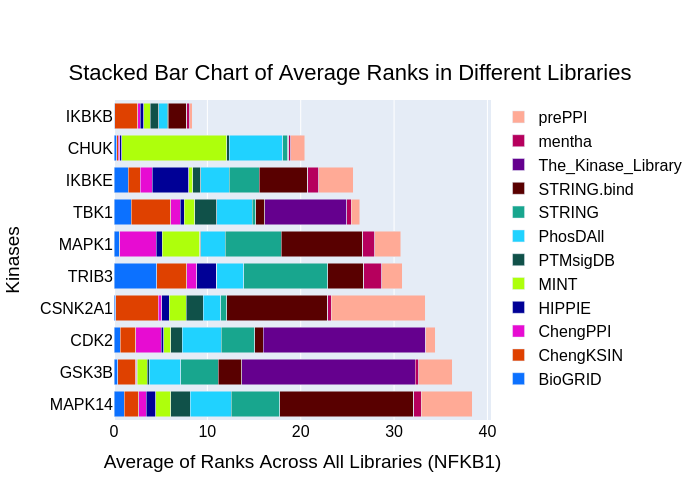

In [38]:
###### Plotting the mean rank data ######

kea3_fig = go.Figure(data = [go.Bar(name = k_lib,
                                    x = k_lib_means[k_lib],
                                    y = sorted_kins,
                                    marker = go.bar.Marker(color = k_lib_palette[k_lib]),
                                    orientation = 'h')
                             for k_lib in kea3libs_sorted])

kea3_fig.update_layout(barmode = 'stack')
kea3_fig.update_layout(
    title = {
        'text': 'Stacked Bar Chart of Average Ranks in Different Libraries',
        'y': 0.87,
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top',
    },
    xaxis_title = 'Average of Ranks Across All Libraries (NFKB1)',
    yaxis_title = 'Kinases',
    font = dict(
        size = 16,
        color = 'black'
    )
)

Image(kea3_fig.to_image(format='png'))

In [39]:
kea3_fig.write_image("kea3_plot NFKB1.png")

###### Figure 3.1
The bar chart above is a mean rank bar chart for the top ranked kinases from KEA3. The y-axis displays the different kinases, and the x-axis displays the mean rank of a specific kinase across all the available libraries.

In [40]:
kea3_mr_table = [0] * len(sorted_topkinresults)

kea3_mr_counter = 0
# set up a counter for indexing (to fill mrtable)

# need to "re-reverse" the ordering for the table (so now we're back to normal ordering)
tbl_sorted_topkinresults = sorted_topkinresults[::-1]
for i in range(0, len(tbl_sorted_topkinresults)):
    tbl_sorted_topkinresults[i]['Rank'] = i + 1

for i in tbl_sorted_topkinresults:
    kea3_mr_table[kea3_mr_counter] = [i['Rank'],
                                      i['TF'],
                                      i['AvgRank'],
                                      i['Library'].replace(',', ': ').replace(';', ', '),
                                      f"{', '.join(i['Overlapping_Genes'].split(',')[0:10])}, ..."]
    # filling mr_table, using replace() to reformat a bit
    # [0:10] for Overlapping_Genes so that only 10 Overlapping Genes are shown (with '...' after)
    kea3_mr_counter += 1

display(HTML(tabulate(kea3_mr_table, ['Rank',
                                      'Kinase',
                                      'Avg Rank',
                                      'Library Ranks',
                                      'Overlapping Genes'],
                      tablefmt='html')))


kea3_tsv_name = 'kinases.tsv'
with open(kea3_tsv_name, 'w') as tsv_file:
    tsv_file.write(tabulate(kea3_mr_table, ['Rank',
                                            'Kinase',
                                            'Avg Rank',
                                            'Library Ranks',
                                            'Overlapping Genes'],
                            tablefmt='tsv'))
    display(HTML(f'<a href="{kea3_tsv_name}">Download table in .tsv</a>'))

Rank,Kinase,Avg Rank,Library Ranks,Overlapping Genes
1,IKBKB,8.36364,"STRING.bind: 22, ChengPPI: 3, PhosDAll: 10, BioGRID: 1, HIPPIE: 4, ChengKSIN: 27, STRING: 1, MINT: 8, mentha: 3, prePPI: 3, PTMsigDB: 10","OTUD4, GSK3B, ATF2, CEBPA, DNMT1, DDX3X, KDM1A, USP11, GPS1, CEBPG, ..."
2,CHUK,20.4545,"STRING.bind: 1, ChengPPI: 2, PhosDAll: 63, BioGRID: 3, HIPPIE: 2, ChengKSIN: 2, STRING: 6, MINT: 124, mentha: 2, prePPI: 17, PTMsigDB: 3","OTUD4, CEBPA, GSK3B, ATF2, DDX3X, KDM1A, USP11, CEBPG, RELA, RELB, ..."
3,IKBKE,25.6364,"STRING.bind: 57, ChengPPI: 14, PhosDAll: 34, BioGRID: 17, HIPPIE: 43, ChengKSIN: 14, STRING: 35, MINT: 5, mentha: 13, prePPI: 41, PTMsigDB: 9","GSK3B, CREBBP, DDX3X, KDM1A, GPS1, USP2, TRAF2, RELA, RELB, PCMT1, ..."
4,TBK1,26.3333,"STRING.bind: 12, ChengPPI: 12, PhosDAll: 46, BioGRID: 22, HIPPIE: 5, ChengKSIN: 51, STRING: 4, MINT: 14, The_Kinase_Library: 105, mentha: 6, prePPI: 11, PTMsigDB: 28","OTUB2, GSK3B, ATF2, DNMT1, DDX3X, KDM1A, GPS1, CEBPG, RELA, RELB, ..."
5,MAPK1,30.7273,"STRING.bind: 96, ChengPPI: 43, PhosDAll: 29, BioGRID: 6, HIPPIE: 7, ChengKSIN: 1, STRING: 66, MINT: 44, mentha: 14, prePPI: 31, PTMsigDB: 1","ATF2, CEBPA, GSK3B, DNMT1, DDX3X, WDR26, KDM1A, CEBPE, GPS1, CEBPG, ..."
6,TRIB3,30.8889,"STRING.bind: 35, ChengPPI: 10, PhosDAll: 26, BioGRID: 41, HIPPIE: 19, ChengKSIN: 29, STRING: 81, mentha: 17, prePPI: 20","OTUD4, CEBPA, GSK3B, DNMT1, WDR26, DDX3X, KDM1A, USP11, CEBPG, RELA, ..."
7,CSNK2A1,33.3636,"STRING.bind: 119, ChengPPI: 4, PhosDAll: 21, BioGRID: 2, HIPPIE: 9, ChengKSIN: 50, STRING: 7, MINT: 20, mentha: 4, prePPI: 111, PTMsigDB: 20","OTUD4, ATF2, GSK3B, CEBPA, DNMT1, DDX3X, WDR26, KDM1A, CEBPE, USP11, ..."
8,CDK2,34.4167,"STRING.bind: 11, ChengPPI: 33, PhosDAll: 50, BioGRID: 8, HIPPIE: 3, ChengKSIN: 20, STRING: 43, MINT: 9, The_Kinase_Library: 208, mentha: 1, prePPI: 12, PTMsigDB: 15","OTUD4, ATF2, CEBPA, GSK3B, DNMT1, DDX3X, WDR26, KDM1A, GPS1, USP11, ..."
9,GSK3B,36.25,"STRING.bind: 30, ChengPPI: 1, PhosDAll: 41, BioGRID: 5, HIPPIE: 1, ChengKSIN: 23, STRING: 48, MINT: 13, The_Kinase_Library: 223, mentha: 5, prePPI: 43, PTMsigDB: 2","OTUD4, OTUB2, GSK3B, CEBPA, ATF2, DNMT1, DDX3X, KDM1A, CEBPE, GPS1, ..."
10,MAPK14,38.3636,"STRING.bind: 158, ChengPPI: 9, PhosDAll: 48, BioGRID: 12, HIPPIE: 11, ChengKSIN: 17, STRING: 57, MINT: 18, mentha: 9, prePPI: 60, PTMsigDB: 23","ATF2, GSK3B, CEBPA, DNMT1, DDX3X, KDM1A, CEBPE, USP11, GPS1, CEBPG, ..."


###### Table 3.1
The table above represents the top ranked kinases from KEA3. Rows are different kinases, columns are various attributes associated with a single kinase.


In [41]:
x2k_visualizer_input = {'nodes':[], 'interactions':[]}
for tfentry in toptfs:
    x2k_visualizer_input['nodes'].append({'name': tfentry['TF'],
                                          'type': 'tf',
                                          'pvalue': -1})

for kinentry in sorted_topkinresults:
    x2k_visualizer_input['nodes'].append({'name': kinentry['TF'],
                                          'type': 'kinase',
                                          'pvalue': -1})
for tfientry in top_tf_interactors:
    x2k_visualizer_input['nodes'].append({'name': tfientry,
                                          'type': 'other',
                                          'pvalue': -1})

In [42]:
###### Creating 3 Dictionaries For Indexing, One for Each Protein Category ######

index_counter = 0

x2k_visualizer_tfindices = {}
for i in range(0, len(toptfnames)):
    x2k_visualizer_tfindices.update({x2k_visualizer_input['nodes'][i].get('name'):i})
    index_counter = i + 1

x2k_visualizer_kinindices = {}
for i in range(index_counter, index_counter + len(sorted_topkinresults)):
    x2k_visualizer_kinindices.update({x2k_visualizer_input['nodes'][i].get('name'):i})
    index_counter = i + 1

x2k_visualizer_intindices = {}
for i in range(index_counter, index_counter + len(top_tf_interactors)):
    x2k_visualizer_intindices.update({x2k_visualizer_input['nodes'][i].get('name'):i})

In [43]:
###### Connecting TFs and Interactors ######

for tf in toptfnames:
    for i in top_dict.get(tf):
        if top_dict.get(tf) != 'No known interactors':
            tfint_interaction = {'source': x2k_visualizer_tfindices.get(tf),
                                 'target': x2k_visualizer_intindices.get(i)}
        if i in top_tf_interactors and tfint_interaction not in x2k_visualizer_input['interactions']:
            x2k_visualizer_input['interactions'].append(tfint_interaction)

In [44]:
overlapping_genelist1 = [i['Overlapping_Genes'] for i in sorted_topkinresults]

overlapping_genelist2 = []
for genelist in overlapping_genelist1:
    gene = genelist.split(',')
    overlapping_genelist2.append(gene)

# overlapping_genelist2 is a list of lists, where the list indices correspond to
# a single kinases index in sorted_topkinresults (index 3 of sorted_topkinresults will
# have the overlapping genes in index 3 of overlapping_genelist2)

int_kin_interactions = {}
for kin_genelist in overlapping_genelist2:
    for gene in kin_genelist:
        int_kin_interactions.update({gene:[]})

new_sorted_topkinresults = [i.copy() for i in sorted_topkinresults]
for i in range(len(new_sorted_topkinresults)):
    new_sorted_topkinresults[i].update({'Overlapping_Genes':overlapping_genelist2[i]})

for i in int_kin_interactions.keys():
    for j in new_sorted_topkinresults:
        if i in j['Overlapping_Genes']:
            int_kin_interactions[i].append(j['TF'])

In [45]:
for a in int_kin_interactions.keys():
    for b in int_kin_interactions.get(a):
        intkin_interaction = {'source': x2k_visualizer_intindices.get(a),
                              'target': x2k_visualizer_kinindices.get(b)}
        if intkin_interaction not in x2k_visualizer_input['interactions']:
            x2k_visualizer_input['interactions'].append(intkin_interaction)

In [46]:
full_x2k_visualizer_input = {}
full_x2k_visualizer_input['X2K'] = x2k_visualizer_input

full_x2k_visualizer_input.update([ ('ChEA', []), ('KEA', []), ('G2N', {}), ('input', []) ])

## X2K Network Visualization

In [47]:
display(HTML("<style>.observable-link ~ iframe { height: 700px !important; }</style>"))
embed('@maxim-k/x2k-network', cells=['x2k'], inputs={'json': full_x2k_visualizer_input})

In [48]:
# -----------------------------
# Sanitize X2K input for Observable
# -----------------------------
def sanitize_x2k_input(data):
    # Nodes: top-level or under 'network'
    if "nodes" in data:
        nodes = data["nodes"]
    elif "network" in data and "nodes" in data["network"]:
        nodes = data["network"]["nodes"]
    else:
        nodes = []

    # Ensure all nodes have 'name'
    for i, node in enumerate(nodes):
        if "name" not in node:
            node["name"] = f"Node{i}"

    # Edges: top-level or under 'network'
    if "edges" in data:
        edges = data["edges"]
    elif "network" in data and "edges" in data["network"]:
        edges = data["network"]["edges"]
    else:
        edges = []

    # Keep only edges pointing to valid nodes
    max_index = len(nodes) - 1
    edges = [
        e for e in edges
        if isinstance(e.get("source"), int)
        and isinstance(e.get("target"), int)
        and 0 <= e["source"] <= max_index
        and 0 <= e["target"] <= max_index
    ]

    # Write back cleaned edges
    if "edges" in data:
        data["edges"] = edges
    elif "network" in data:
        data["network"]["edges"] = edges

    return data

# -----------------------------
# Apply sanitization
# -----------------------------
full_x2k_visualizer_input = sanitize_x2k_input(full_x2k_visualizer_input)


In [49]:
from IPython.display import display, HTML
from observable_jupyter import embed

# Optional: make iframe taller
display(HTML("<style>.observable-link ~ iframe { height: 700px !important; }</style>"))

# Embed the X2K network
embed(
    '@maxim-k/x2k-network',
    cells=['x2k'],
    inputs={'json': full_x2k_visualizer_input}
)


In [50]:
`full_x2k_visualizer_input["edges"] = [
    e for e in full_x2k_visualizer_input["edges"]
    if e["source"] is not None and e["target"] is not None
]


KeyError: 'edges'

In [ ]:
if "edges" in full_x2k_visualizer_input:
    edges = full_x2k_visualizer_input["edges"]
elif "network" in full_x2k_visualizer_input and "edges" in full_x2k_visualizer_input["network"]:
    edges = full_x2k_visualizer_input["network"]["edges"]
else:
    edges = []

# Clean edges
edges = [e for e in edges if e.get("source") is not None and e.get("target") is not None]

# Put back in the right place
if "edges" in full_x2k_visualizer_input:
    full_x2k_visualizer_input["edges"] = edges
else:
    full_x2k_visualizer_input["network"]["edges"] = edges


In [ ]:
# --- Clean up edges in full_x2k_visualizer_input for X2K visualization ---
# Handles cases where "edges" might live at the top level OR under "network"

if "edges" in full_x2k_visualizer_input:
    edges = full_x2k_visualizer_input["edges"]
elif "network" in full_x2k_visualizer_input and "edges" in full_x2k_visualizer_input["network"]:
    edges = full_x2k_visualizer_input["network"]["edges"]
else:
    edges = []

# Keep only edges with valid source/target values
edges = [
    e for e in edges
    if e.get("source") is not None and e.get("target") is not None
]

# Put cleaned edges back in the correct place
if "edges" in full_x2k_visualizer_input:
    full_x2k_visualizer_input["edges"] = edges
elif "network" in full_x2k_visualizer_input:
    full_x2k_visualizer_input["network"]["edges"] = edges


In [ ]:
nodes = None
if "nodes" in full_x2k_visualizer_input:
    nodes = full_x2k_visualizer_input["nodes"]
elif "network" in full_x2k_visualizer_input and "nodes" in full_x2k_visualizer_input["network"]:
    nodes = full_x2k_visualizer_input["network"]["nodes"]

if nodes is not None:
    for i, node in enumerate(nodes):
        if "name" not in node:
            node["name"] = f"Node{i}"  # fallback name


In [ ]:
import json
print(json.dumps(full_x2k_visualizer_input, indent=2))


In [ ]:
for i, node in enumerate(full_x2k_visualizer_input.get("nodes", [])):
    if "name" not in node:
        node["name"] = f"Node{i}"

###### Figure 4.1
The figure above is an X2K Network visualization. Red nodes represent transcription factors (tfs), white notes represent intermediate proteins/transcription factor interactors, and blue nodes represent kinases. Conencting the nodes, white lines represent a protein-protein interaction (PPI) between tfs and their interactors, and green lines represent phosphorylation of kinases.